In [1]:
import pandas as pd
stat_file = pd.DataFrame({'model':[],
                  'model_params':[],
                  'opt_params':[],
                  'run_number':[],
                  'epoch':[],
                  'validation_or_train':[],
                  'accuracy':[],
                  'loss':[],
                'additional_info':[]})
stat_file

,model,model_params,opt_params,run_number,epoch,validation_or_train,accuracy,loss,additional_info


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json


In [3]:
import torch
import torch.nn as nn
import math

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, context_length):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(context_length, hidden_size)
        self.token_type_embeddings = nn.Embedding(2, hidden_size)

    def forward(self, input_ids, token_type_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        return embeddings


class LayerNorm(nn.Module):
    def __init__(self, normalized_shape,  eps=0.00001):
        super().__init__()
        self.eps=eps
        self.normalized_shape=normalized_shape
        self.gamma = nn.Parameter(torch.ones((1,1,self.normalized_shape)), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros((1,1,self.normalized_shape)), requires_grad=True)

    def forward(self, input):
        """

        Args:
            input (torch.Tensor): (B, T, C)

        Returns:
            torch.Tensor: (B, T, C)
        """
        mean = torch.mean(input, dim=-1, keepdim=True)
        var = torch.var(input, dim=-1, keepdim=True,  unbiased=False)
        
        out = (input - mean) / torch.sqrt(var+self.eps) * self.gamma + self.beta
        
        return out


class MultiHeadAttention(nn.Module):

    def __init__(self, model_dim, n_heads, p_dropout = 0.0):

        super().__init__()
        assert model_dim % n_heads == 0
        
        self.dim = model_dim 
        self.n_heads=n_heads
        self.head_dim = self.dim // self.n_heads
        

        self.qkv = nn.Linear(model_dim, 3 * model_dim, bias=True)

        self.dropout = nn.Dropout(p=p_dropout)

        self.proj = nn.Linear(model_dim, model_dim, bias=True)#part of attention

        

    def forward(self, input, attn_mask):
        """_summary_

        Args:
            input (torch.tensor): (B,T,C)
            attn_mask (torch.tensor): (B,T)

        Returns:
            _type_: _description_
        """

        #Mutihead attention
        qkv = self.qkv(input) # фееутешщт ьфыл шт иуке(B, T, 3*dim)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
    
        q = q.view(input.size(0), input.size(1), self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
        k = k.view(input.size(0), input.size(1), self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)
        v = v.view(input.size(0), input.size(1), self.n_heads, self.head_dim).transpose(1, 2)  # (B, n_heads, T, head_dim)

        weights = q @ k.transpose(-2,-1) * self.head_dim**(-0.5) # (B,n_heads, T , T)

        
        weights = weights.masked_fill(attn_mask.unsqueeze(1).unsqueeze(2) == 0, -torch.inf)
        
        weights = torch.nn.functional.softmax (weights, dim=3)

        weights = self.dropout(weights)
        
        out = weights @ v
        
        out=out.transpose(1,2) # (B,T, n_heads , head_dim)
        
        #Concatenation of heads
        out = out.reshape(out.size(0), out.size(1),-1) # (B,T, C)
        out = self.proj(out)

        return out


class TransfomerBlock(nn.Module):

    def __init__(self, model_dim, n_heads, max_seq_len, p_dropout = 0.0):

        super().__init__()
        assert model_dim % n_heads == 0
        
        self.dim = model_dim 
        self.n_heads=n_heads
        self.head_dim = self.dim // self.n_heads
        

        self.mha = MultiHeadAttention(model_dim, n_heads, max_seq_len)

        self.ln1 = LayerNorm(model_dim)

        self.dropout= nn.Dropout(p=p_dropout)

        self.mlp = nn.Sequential(nn.Linear(model_dim, 4*model_dim),
                                 nn.GELU(),
                                 nn.Linear(4*model_dim, model_dim),
                                 )
        
        self.ln2 = LayerNorm(model_dim)


    def forward(self, input, mask):
        """_summary_

        Args:
            input (torch.tensor): input for block with dimensions: (B, T, C), where B - batch, T - sequence length, C - model size
            mask (torch.tensor): (B, T)
        Returns:
            Next tokens for each k-gram. Shape : # (B,T, C)
        """
        residual_1 = input
        
        #Mutihead attention
        out = self.mha (input, mask)

        out = self.ln1 (out)

        out = self.dropout(out)
        #Add
        out = residual_1 + out

        residual_2 = out
        
        #Feed forward
        out = self.mlp (out)

        out = self.ln2(out)

        out = self.dropout(out)
        #Add
        out = residual_2 + out
        


        return out



class Transformer(nn.Module):
    """
    Encoder-only transofrmer.
    forward method takes sequences with the same lengthes as input, and then attention mask applied for pad tokens
    """
        
    def __init__(self, vocab_size, model_dim, n_heads, max_seq_len, n_blocks, p_dropout=0.0):
        super().__init__()
        self.vocab_size, self.model_dim, self.n_heads, self.max_seq_len, self.n_blocks = vocab_size, model_dim, n_heads, max_seq_len, n_blocks
        self.emb  = BertEmbeddings(vocab_size, model_dim,max_seq_len)
        self.emb_ln = LayerNorm(model_dim)
        self.dropout = nn.Dropout(p=p_dropout)
        self.net = nn.ModuleList([TransfomerBlock(model_dim, n_heads,p_dropout) for _ in range (n_blocks)])
       
        self.final_linear = nn.Linear(model_dim, model_dim)
        self.activation = nn.Tanh()


    def forward(self, input, attn_mask, token_type_ids):
        """
        input (torch.Tensor): batch of data to predict logits on. (B, T, C)
        Args:
            input (torch.Tensor): batch of data to predict logits on. (B, T, C)
            attn_mask (torch.Tensor): pad tokens indicator. (B, T)
        Returns:
            torch.Tensor: Tensors with logits. nan where pad token. (B, T, vocab_size) - mlm_logits, (B, 2)- nsp logits
        """
        
        embs = self.emb(input, token_type_ids)

        embs = self.emb_ln (embs)

        embs = self.dropout(embs)

        for encoder in self.net:
            embs = encoder.forward(embs, attn_mask)

        hidden = embs

        out = self.final_linear(embs)#(B, T, C)

        out = self.activation(out)

        return hidden, out
    

class BertPooler(nn.Module):
        def __init__(self, model_dim):
            super().__init__()
            self.dense = nn.Linear(model_dim, model_dim)
            self.activation = nn.Tanh()

        def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
            # We "pool" the model by simply taking the hidden state corresponding
            # to the first token.
            first_token_tensor = hidden_states[:, 0, :]
            #print(first_token_tensor.shape)
            pooled_output = self.dense(first_token_tensor)
            pooled_output = self.activation(pooled_output)
            return pooled_output
        
class CustomBertForClassification(nn.Module):


    
        
    def __init__(self, bert_base, hidden_dim, num_labels):

        super().__init__()
        self.bert_base = bert_base
        self.hidden_dim = hidden_dim
        self.num_labels=num_labels
        self.pooler = BertPooler(bert_base.model_dim)
        self.classification_head = nn.Sequential(nn.Linear(bert_base.model_dim,hidden_dim ),
                                                 nn.ReLU(),
                                                 nn.Linear(hidden_dim, num_labels))
        
        
    def forward(self, input, attn_mask, token_type_ids):
        """_summary_

        Args:
            input (_type_): _description_
            attn_mask (_type_): _description_
            token_type_ids (_type_): _description_

        Returns:
            torch.Tensor: logits for num_labels classes
        """

        hidden, out = self.bert_base(input, attn_mask, token_type_ids)
        #print(out.shape)
        out=self.pooler(hidden)#Must be applied on hidden state
        out = self.classification_head(out)
        return out



In [4]:
import torch
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
import torch
import pandas as pd
from torch.utils.data import Dataset
import re 
class NewsDataset(Dataset):

    def __preprocess(self, data):
        data = data.fillna('absent')
        
        data.headline[data['headline'].apply(len) == 0] = 'absent'
        data.link[data['link'].apply(len) == 0] = 'absent'
        data.short_description[data['short_description'].apply(len) == 0] = 'absent'
        data.authors[data['authors'].apply(len) == 0] = 'absent'
        return data
        
    def __init__(self, path):
        """_summary_

        Args:
            path (str): path to .json file
        """
        j=pd.read_json(path, lines=True)
        j=self.__preprocess(j)
        
        link = j['link'].str.lower().replace(r'\b(www|http|https|com|html)\b',' ', regex=True)

        
        link = link.apply(lambda l: re.sub('[^a-z A-Z 0-9]+', ' ',l ))

        
        self.x = 'headline: ' +  j['headline'] + \
        ' ; short_description: ' + j['short_description'] + \
        ' ; authors: ' + j['authors'] + \
        ' ; link: ' + link

        
        self.y = j['category'].astype('category').cat.codes
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """

        Args:
            idx (list): _description_

        Returns:
            str: single item
        """
        return {'x':self.x.iloc[idx],'y':self.y.iloc[idx]}
    


In [6]:
train_batch_size=32
eval_batch_size = 200
accumulation_steps = 150

train_test_split = [0.8, 0.2]
val_test_split = [0.5, 0.5]
epochs = 100

In [7]:

from torch.utils.data import DataLoader
ds = NewsDataset('/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json')
from torch.utils.data import Dataset, DataLoader
generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(ds, train_test_split,generator=generator)
val_data, test_data = torch.utils.data.random_split(test_data, val_test_split,generator=generator)

train_dataloader = DataLoader(train_data, batch_size=train_batch_size,
                        shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=eval_batch_size,
                        shuffle=True, num_workers=0)

<ipython-input-5-baa2275c0bce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.headline[data['headline'].apply(len) == 0] = 'absent'
<ipython-input-5-baa2275c0bce>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.link[data['link'].apply(len) == 0] = 'absent'
<ipython-input-5-baa2275c0bce>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.short_description[data['short_description'].apply(len) == 0] = 'absent'
<ipython-

In [8]:
train_data[0]

{'x': 'headline: Make Way For The Goths ; short_description: absent ; authors: Simon McCormack ; link:     huffingtonpost   entry wave gothic festival 2015 n 7436980  ',
 'y': 37}

In [9]:
print('total samples:', len(ds))
print('train samples:', len(train_data))
print('test samples:', len(test_data))

total samples: 209527
train samples: 167622
test samples: 20952


In [10]:
device = 'cuda:0'if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [11]:
model_params = {'model_dim':768,'n_heads':12,'max_seq_len':512,'n_blocks':12, 'MLP_hidden':1024 }
t = Transformer(vocab_size=tokenizer.vocab_size,
                model_dim=model_params['model_dim'],
                n_heads=model_params['n_heads'],
                max_seq_len=model_params['max_seq_len'],
                n_blocks=model_params['n_blocks'])

In [12]:
def get_n_params(model):
    pp=0
    for p in list(model.named_parameters()):
        nn=1
        for s in list(p[1].size()):
            nn = nn*s
        pp += nn
        print(p[0])
        print(nn)
    return pp

In [13]:
from transformers import BertModel
import torch

model = BertModel.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, attn_implementation="sdpa")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
import torch

# Function to load weights from base BERT into the custom model
def load_custom_model_weights(base_model, custom_model):
    custom_model_state_dict = custom_model.state_dict()
    base_model_state_dict = base_model.state_dict()

    # Mapping for the embedding layers
    mapping = {
        "emb.word_embeddings.weight": "embeddings.word_embeddings.weight",
        "emb.position_embeddings.weight": "embeddings.position_embeddings.weight",
        "emb.token_type_embeddings.weight": "embeddings.token_type_embeddings.weight",
        "emb_ln.gamma": "embeddings.LayerNorm.weight",
        "emb_ln.beta": "embeddings.LayerNorm.bias"
    }

    # Mapping for the encoder layers
    for i in range(12):  # Loop through the 12 transformer layers
        mapping.update({
            f"net.{i}.mha.qkv.weight": [
                f"encoder.layer.{i}.attention.self.query.weight",
                f"encoder.layer.{i}.attention.self.key.weight",
                f"encoder.layer.{i}.attention.self.value.weight"
            ],
            f"net.{i}.mha.qkv.bias": [
                f"encoder.layer.{i}.attention.self.query.bias",
                f"encoder.layer.{i}.attention.self.key.bias",
                f"encoder.layer.{i}.attention.self.value.bias"
            ],
            f"net.{i}.mha.proj.weight": f"encoder.layer.{i}.attention.output.dense.weight",
            f"net.{i}.mha.proj.bias": f"encoder.layer.{i}.attention.output.dense.bias",
            f"net.{i}.ln1.gamma": f"encoder.layer.{i}.attention.output.LayerNorm.weight",
            f"net.{i}.ln1.beta": f"encoder.layer.{i}.attention.output.LayerNorm.bias",
            f"net.{i}.mlp.0.weight": f"encoder.layer.{i}.intermediate.dense.weight",
            f"net.{i}.mlp.0.bias": f"encoder.layer.{i}.intermediate.dense.bias",
            f"net.{i}.mlp.2.weight": f"encoder.layer.{i}.output.dense.weight",
            f"net.{i}.mlp.2.bias": f"encoder.layer.{i}.output.dense.bias",
            f"net.{i}.ln2.gamma": f"encoder.layer.{i}.output.LayerNorm.weight",
            f"net.{i}.ln2.beta": f"encoder.layer.{i}.output.LayerNorm.bias"
        })

    # Mapping for the final pooler layer
    mapping.update({
        "final_linear.weight": "pooler.dense.weight",
        "final_linear.bias": "pooler.dense.bias"
    })

    # Copy the weights
    for custom_param, base_param in mapping.items():
        if isinstance(base_param, list):  # Handle combined qkv weights and biases
            qkv_weight = torch.cat([
                base_model_state_dict[base_param[0]],
                base_model_state_dict[base_param[1]],
                base_model_state_dict[base_param[2]]
            ], dim=0)
            custom_model_state_dict[custom_param].copy_(qkv_weight)
        else:
            custom_model_state_dict[custom_param].copy_(base_model_state_dict[base_param])

    custom_model.load_state_dict(custom_model_state_dict)
    print("Weights successfully loaded from base model into custom model.")


In [15]:
load_custom_model_weights(model, t)

Weights successfully loaded from base model into custom model.


In [16]:
import torch.nn as nn

In [17]:

classification_bert = CustomBertForClassification(t, model_params['MLP_hidden'], 42)

classification_bert.to(device)

#for param in classification_bert.bert_base.parameters():
#    param.requires_grad = False

CustomBertForClassification(
  (bert_base): Transformer(
    (emb): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
    )
    (emb_ln): LayerNorm()
    (dropout): Dropout(p=0.0, inplace=False)
    (net): ModuleList(
      (0-11): 12 x TransfomerBlock(
        (mha): MultiHeadAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln1): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln2): LayerNorm()
      )
    )
    (final_linear): Linear(in_features=768, out_fe

In [18]:
def evaluate(classification_bert, test_dataloader):
    with torch.no_grad():
            matches=0
            number_of_iters = 0
            for b_eval in test_dataloader:
                tokenized = tokenizer(b_eval['x'], padding=True, return_tensors="pt")
                tokenized.to(device)
                ids, mask, token_type_ids = tokenized['input_ids'], tokenized['attention_mask'], tokenized['token_type_ids']
                preds = classification_bert(ids, mask, token_type_ids)
                matches += torch.sum(torch.isclose(b_eval['y'].long().to(device), torch.argmax(preds, dim=1)))
                loss = criterion(preds, b_eval['y'].long().to(device))
                
            accuracy = matches / len(test_dataloader.dataset)
            print('accuracy: ', accuracy)
    return accuracy, loss

In [19]:
LRs=[]
epoch_loss = []
epoch_acc_train=[]
epoch_acc_test=[]
run_number=0

In [20]:
def insert_row(df, row):
    return pd.concat([df, row], ignore_index=True)

In [21]:
optimizer_params = {'lr':0.00035, 'step_size':10, 'gamma':0.1}

In [22]:
run_number+=1
def train(model, epochs, optimizer, criterion, scheduler, callback, callback_freq, additional_info):
    global stat_file
    for epoch_num in range(1,epochs):
        
        accuracies_test=  []
        accuracies_train=  []
        losses=[]
        
        ttl_loss=0
        train_iters=0
        for i, train_batch in enumerate(train_dataloader):
            
            # Tokenize and pad
            tokenized = tokenizer(train_batch['x'], padding=True, return_tensors="pt")
            tokenized.to(device)
        
            # Create tensor for input batch
            ids, mask, token_type_ids = tokenized['input_ids'], tokenized['attention_mask'], tokenized['token_type_ids']
            
            preds = model(ids, mask,token_type_ids )
            loss = criterion(preds, train_batch['y'].long().to(device))
            
            ttl_loss+=loss.item()
            train_iters+=1
            
            loss.backward()
            
            
            if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
                optimizer.step()                            # Now we can do an optimizer step
                model.zero_grad()
                
                print('loss', ttl_loss / train_iters)
                losses.append(ttl_loss / train_iters)
            
                
                ttl_loss=0
                train_iters=0
                
                
                train_accuracy = torch.sum(torch.isclose(train_batch['y'].long().to(device), torch.argmax(preds, dim=1))) / train_batch_size
                accuracies_train.append(train_accuracy)
                print('train accuracy: ',train_accuracy )
    
                row = {'model': model.__class__,
                'model_params':str(model_params),
                'opt_params':str(optimizer_params),
                'run_number':run_number,
                'epoch':epoch_num,
                'validation_or_train':'train',
                'accuracy':train_accuracy,
                'loss':losses[-1],
                  'additional_info':additional_info}
        
                stat_file = insert_row(stat_file, pd.DataFrame(row, index=[len(stat_file)]))
                
            del preds
            del tokenized
            del loss
    
        scheduler.step()
        
        print('epoch ',str(epoch_num),'lr', scheduler.get_last_lr())
        LRs.append(scheduler.get_last_lr())

        if epoch_num % callback_freq == 0:
            accuracy, loss_val = evaluate(model, val_dataloader)
            epoch_acc_test.append(accuracy)
            print('accuracy: ', accuracy)
        
            row = {'model': model.__class__,
                    'model_params':str(model_params),
                    'opt_params':str(optimizer_params),
                    'run_number':run_number,
                    'epoch':epoch_num,
                    'validation_or_train':'validation',
                    'accuracy':accuracy,
                    'loss':loss_val,
                    'additional_info':additional_info}
            
            stat_file = insert_row(stat_file, pd.DataFrame(row, index=[len(stat_file)]))
        
        epoch_acc_train.append(accuracies_train)
        
        epoch_loss.append(losses)
        torch.save(model.state_dict(), 'weights'+str(epoch_num)+'.pt')

In [23]:

callback_freq = 1
epochs = 30
optimizer = torch.optim.Adam(classification_bert.parameters(), lr=optimizer_params['lr'])
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=optimizer_params['step_size'],
                                            gamma=optimizer_params['gamma'])


train(model=classification_bert,
      epochs=epochs,
      optimizer=optimizer,
      criterion=criterion,
      scheduler=scheduler,
      callback=evaluate,
      callback_freq=1,
     additional_info='bert-base-uncased finetning ; not frozen')

loss 3.790989918708801
train accuracy:  tensor(0.0312, device='cuda:0')
loss 3.4425605948766074
train accuracy:  tensor(0.1875, device='cuda:0')
loss 3.3814472643534343
train accuracy:  tensor(0.2812, device='cuda:0')
loss 3.3608363501230873
train accuracy:  tensor(0.0312, device='cuda:0')
loss 3.3217971658706666
train accuracy:  tensor(0.1250, device='cuda:0')
loss 3.300185596148173
train accuracy:  tensor(0.1250, device='cuda:0')
loss 3.27616348584493
train accuracy:  tensor(0.0938, device='cuda:0')
loss 3.2882216787338256
train accuracy:  tensor(0.2188, device='cuda:0')
loss 3.285924466451009
train accuracy:  tensor(0.1875, device='cuda:0')
loss 3.2745680459340414
train accuracy:  tensor(0.1875, device='cuda:0')
loss 3.263511452674866
train accuracy:  tensor(0.2188, device='cuda:0')
loss 3.2237898747126263
train accuracy:  tensor(0.1250, device='cuda:0')
loss 3.2027438767751057
train accuracy:  tensor(0.1562, device='cuda:0')
loss 3.1705947287877403
train accuracy:  tensor(0.3125, d

KeyboardInterrupt: 

In [24]:
stat_file.to_csv('bert_3.csv')

In [27]:
def get_parameter_ratios(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    ratio = trainable_params / total_params
    return trainable_params, total_params, ratio

# Usage
trainable_params, total_params, ratio = get_parameter_ratios(classification_bert)
print(f"Trainable Parameters: {trainable_params}")
print(f"Total Parameters: {total_params}")
print(f"Ratio: {ratio:.2%}")


Trainable Parameters: 110903338
Total Parameters: 110903338
Ratio: 100.00%


In [ ]:
stat_file

In [40]:
np.array(epoch_loss).mean(axis=1)

array([3.31295367, 3.28931011, 3.23713106, 2.83262394, 2.70494098,
       2.59025799, 2.56006351, 2.54057596, 2.5210469 , 2.50541966,
       2.49069468, 2.48609753, 2.48430502, 2.4799923 , 2.47822647,
       2.4762014 , 2.47648914, 2.4759769 , 2.47362136, 2.47452816,
       2.47414314, 2.47444618, 2.47411982])

In [31]:
acc_test_epoch = [a.cpu() for a in epoch_acc_test]

In [32]:
acc_train_epoch = []
for a in epoch_acc_train:
    acc_train_epoch.append([b.cpu() for b in a ])
acc_train_epoch = np.array(acc_train_epoch).mean(axis=1)



In [33]:
acc_train_epoch

array([0.24724264, 0.6351103 , 0.77297795, 0.8327206 , 0.85294116,
       0.88143384, 0.9117647 , 0.9108456 , 0.9338235 , 0.92922795,
       0.92830884, 0.9319853 , 0.9393382 , 0.9237132 , 0.9503676 ,
       0.9476103 , 0.94669116, 0.9420956 ], dtype=float32)

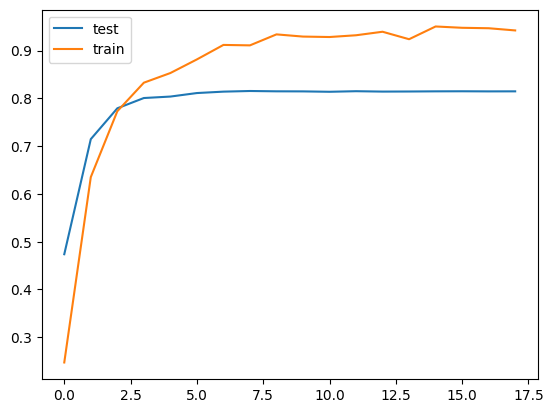

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
ax.plot(np.arange(len(acc_test_epoch)), acc_test_epoch, label='test')
ax.plot(np.arange(len(acc_train_epoch)), acc_train_epoch, label='train')
plt.legend()

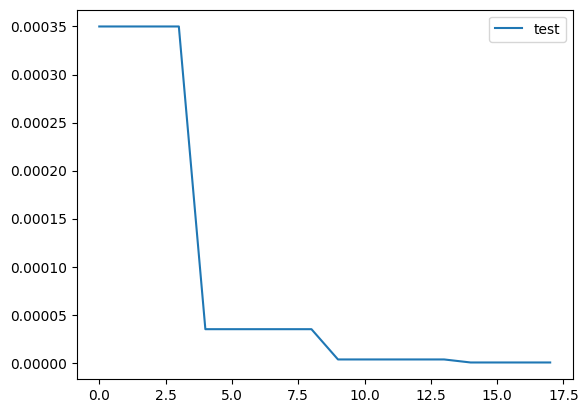

In [35]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(LRs)), LRs, label='test')
plt.legend()

In [36]:
test_dataloader = DataLoader(test_data, batch_size=train_batch_size,
                        shuffle=True, num_workers=0)

In [37]:
evaluate(classification_bert, test_dataloader)

accuracy:  tensor(0.8102, device='cuda:0')


tensor(0.8102, device='cuda:0')